# Comparison with Satellite Laser Ranging (SLR) TWSA

In this notebook, we compare our TWS reconstruction to a TWS product from IGG Bonn which combines gravity field measurements of SLR and DORIS.

In [1]:
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [4]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [5]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"
slr_store = ROOT_DIR / "data/processed/igg-slr-hybrid-2.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
slr = xr.open_zarr(slr_store)
recs = xr.open_zarr(recs_store)


In [6]:
# Resample SLR data set from 1° to 0.5°
step = 0.5
lat_05 = np.arange(89.75, -89.75 - step, -step)
lon_05 = np.arange(-179.75, 179.75 + step, step)
slr = slr.interp(lat=lat_05, lon=lon_05, method="nearest")


In [7]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, slr, recs, ours])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [ ]:
vars_verbose = {
    "twsa_ours_era": "DeepRec",
    "twsa_ours_wghm-era": "DeepRec, w/ WGHM",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "twsa_csr": "CSR GRACE",
}
eval_names = vars_verbose.keys()


In [9]:
grace_name = "twsa_csr"
slr_name = "twsa_slr_2024"


Remove time steps not available in the evaluation product:

In [10]:
ds_slrtime = ds_all[[*eval_names, slr_name]].where(slr.time, drop=True).compute()

[########################################] | 100% Completed | 6.12 s


Calculate basin averages:

In [11]:
# Dims: ("model", "region")
ds_basin = (
    # Basins over 200,000 km²
    ds_slrtime.chunk(lat=-1, lon=-1, time=10)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
).compute()
ds_basin


[########################################] | 100% Completed | 68.77 s


<xarray.Dataset> Size: 1MB
Dimensions:                (time: 252, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 1995-01-01 ... 2015-12-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    twsa_ours_era          (region, time) float64 145kB -14.01 17.48 ... -38.9
    twsa_ours_wghm-era     (region, time) float64 145kB 20.39 65.17 ... -41.01
    twsa_gap               (region, time) float64 145kB 18.66 56.66 ... 37.66
    humphrey_gsfc_detrend  (region, time) float64 145kB -30.14 27.02 ... -90.61
    li_csr_full            (region, time) float64 145kB -65.78 9.697 ... -48.93
    yin_csr_full           (region, time) float64 145kB -21.15 35.06 ... -38.48
    palazzoli_jpl_full     (region, time) float64 145kB 7.447 47.01 ... -65.58
    twsa_csr               (region, time) float64 145kB nan nan nan ... nan nan
    twsa_slr_2024          (region, time) float64 145kB 2.271 25.5 ... -18.64

Split into Pre-GRACE and GRACE periods:

In [12]:
ds_basin_pre = ds_basin.drop_vars(grace_name).sel(time=slice(None, "2001"))
ds_basin_post = ds_basin.sel(time=slice("2002", None))
# Drop time stamps which are not available for at least one variable
ds_basin_pre = ds_basin_pre.where(ds_basin_pre.dr.time_notnull("region"), drop=True)
ds_basin_post = ds_basin_post.where(ds_basin_post.dr.time_notnull("region"), drop=True)

In [13]:
ds_basin


<xarray.Dataset> Size: 1MB
Dimensions:                (time: 252, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 1995-01-01 ... 2015-12-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    twsa_ours_era          (region, time) float64 145kB -14.01 17.48 ... -38.9
    twsa_ours_wghm-era     (region, time) float64 145kB 20.39 65.17 ... -41.01
    twsa_gap               (region, time) float64 145kB 18.66 56.66 ... 37.66
    humphrey_gsfc_detrend  (region, time) float64 145kB -30.14 27.02 ... -90.61
    li_csr_full            (region, time) float64 145kB -65.78 9.697 ... -48.93
    yin_csr_full           (region, time) float64 145kB -21.15 35.06 ... -38.48
    palazzoli_jpl_full     (region, time) float64 145kB 7.447 47.01 ... -65.58
    twsa_csr               (region, time) float64 145kB nan nan nan ... nan nan
    twsa_slr_2024          (region, time) float64 145kB 2.271 25.5 ... -18.64

In [ ]:
times_pre = ds_basin_pre.get_index("time")
print(f"Timespan pre-GRACE: {times_pre[0].date()} to {times_pre[-1].date()}")

times_post = ds_basin_post.get_index("time")
print(f"Timespan GRACE/-FO: {times_post[0].date()} to {times_post[-1].date()}")

Timespan pre-GRACE: 1995-01-01 to 2001-12-01
Timespan post-GRACE: 2002-04-01 to 2015-09-01


### Basin scale PCC

In [15]:
# Calculate PCC for pre-GRACE era
da_pcc_pre = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_pre.drop_vars(slr_name),
    ds_basin_pre[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")

# Calculate PCC for GRACE era
da_pcc_post = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_post.drop_vars(slr_name),
    ds_basin_post[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")


In [16]:
# Combine along new `era` dimension
pcc_basin = xr.concat(
    [da_pcc_pre, da_pcc_post], dim=pd.Index(["pre", "post"], name="era")
)


In [17]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas, for scatter plotting
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)


<Axes: ylabel='model'>

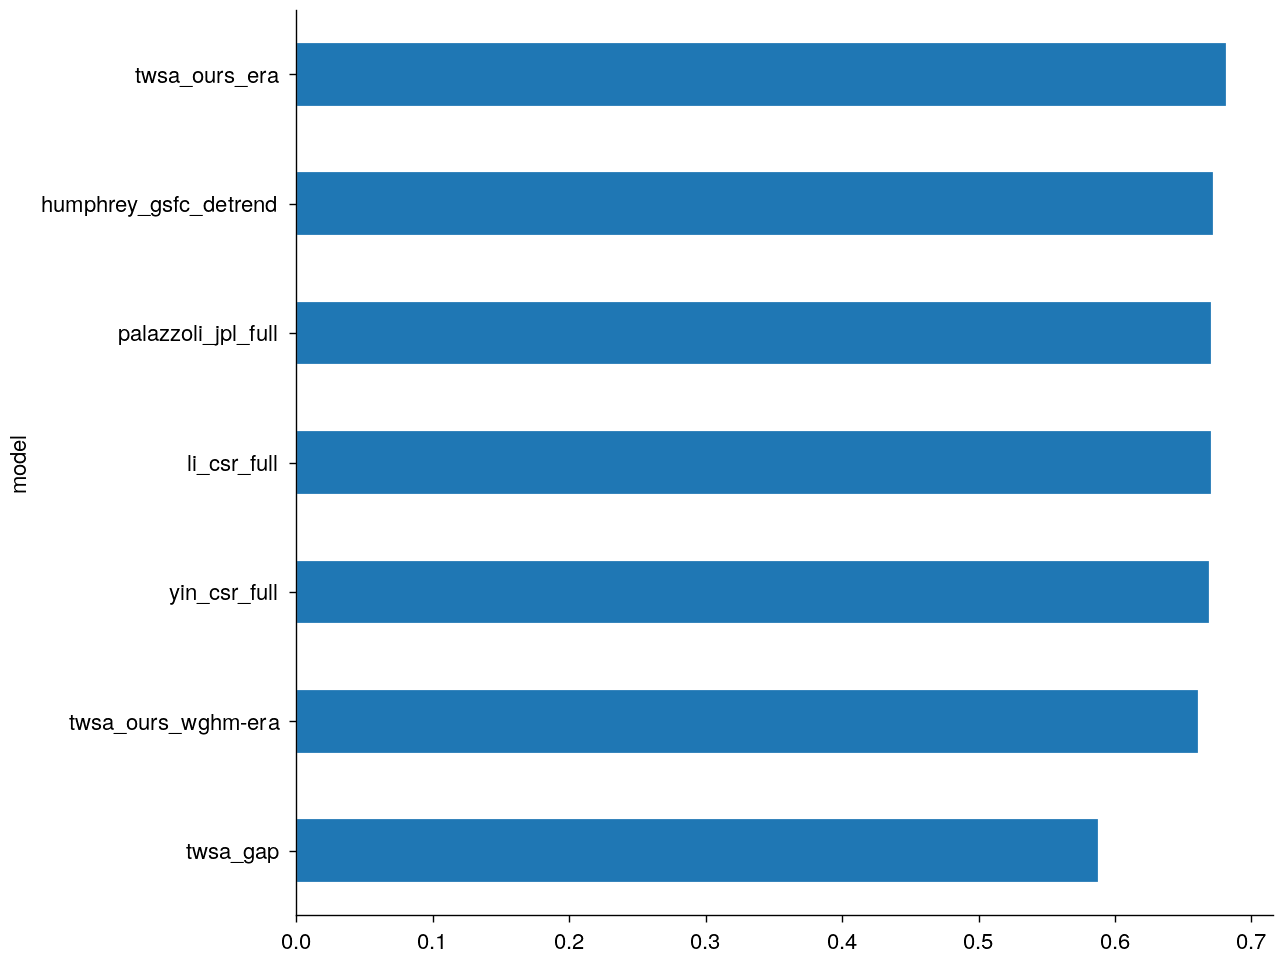

In [18]:
s_pcc_pre_globalavg = (
    da_pcc_pre.weighted(da_basin_areas).mean("region").to_pandas().sort_values()
)
s_pcc_pre_globalavg.plot.barh()

## Map plots

In [19]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap=cmc.lipari_r,
    vmin=0,
    vmax=1,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02, label="PCC"),
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.3, facecolor="None", rasterized=True, zorder=3.0
)


In [20]:
# Create a dummy array with the dimensions (model x lat x lon)
da_dummy_post = ds_slrtime[eval_names].isel(time=0, drop=True).to_dataarray("model")
da_dummy_pre = da_dummy_post.drop_sel(model=grace_name)

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:685: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


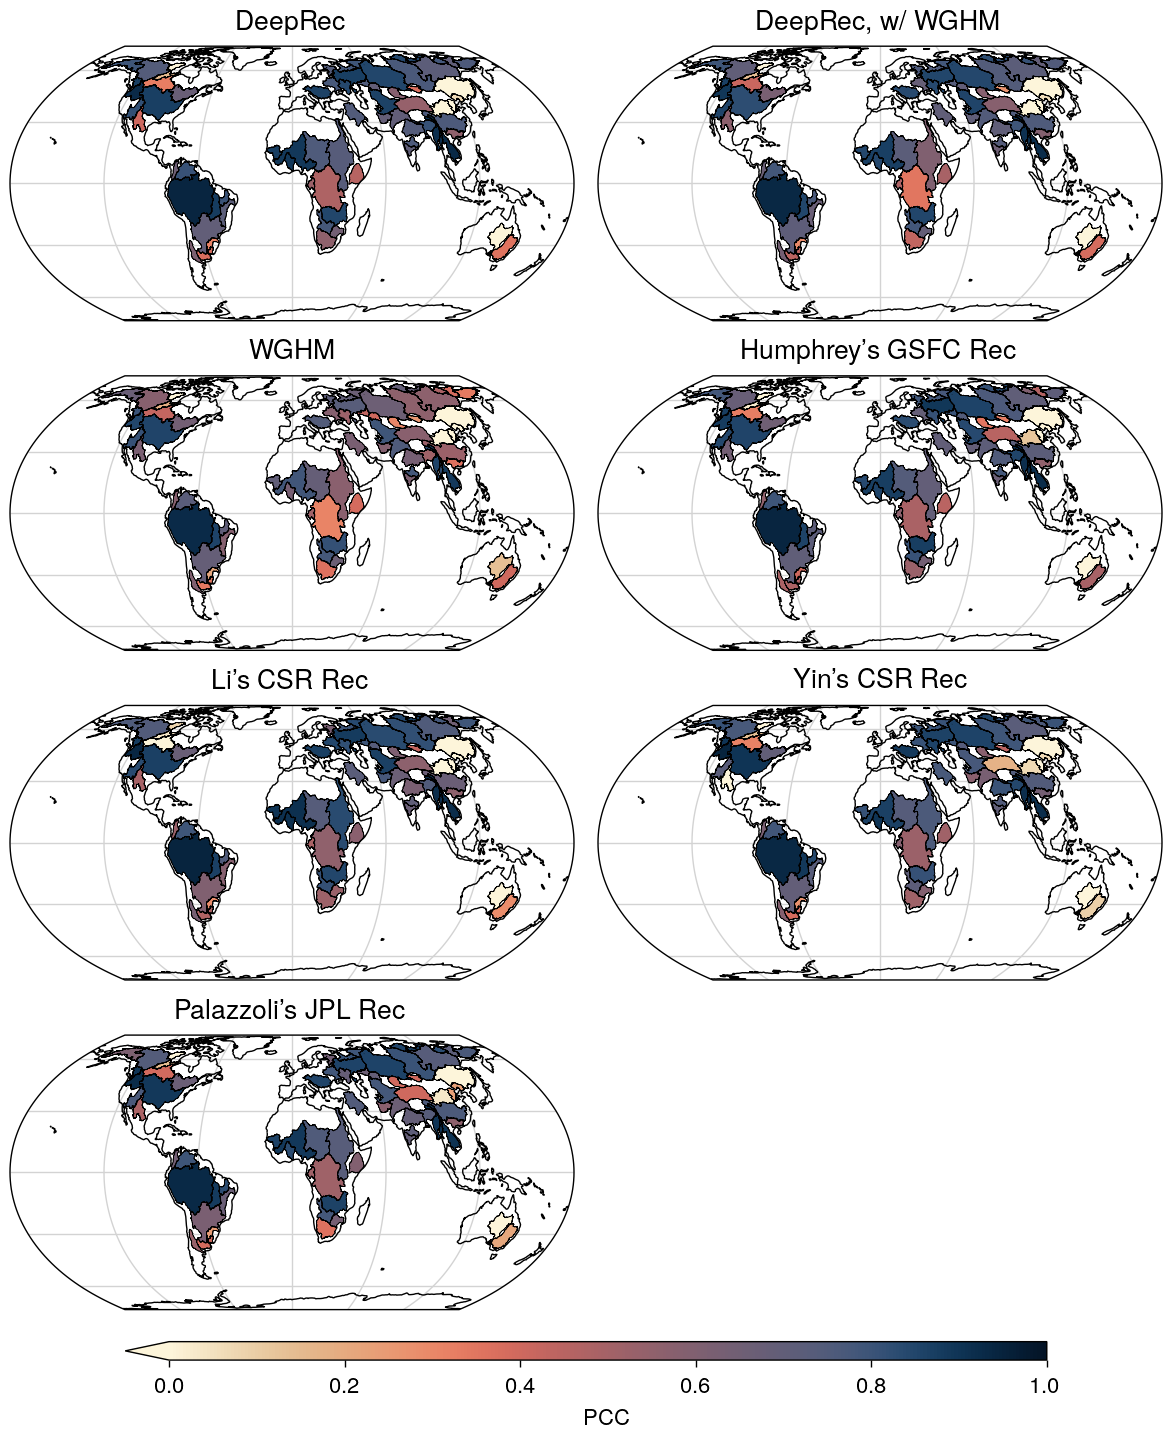

In [21]:
p = da_pcc_pre.dr.projplot_basins(
    da_dummy_pre,
    col="model",
    figsize=(6, 8.25),
    **plot_kwargs,
)

# Plot basin shapes
for ax, model in zip(p.axs.flat, da_pcc_pre.model.values):
    ax.set_title(vars_verbose[model])
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(
    FIGURE_DIR / f"slr_pcc_{times_pre[0].year}-{times_pre[-1].year}.pdf", backend="pgf"
)


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:685: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


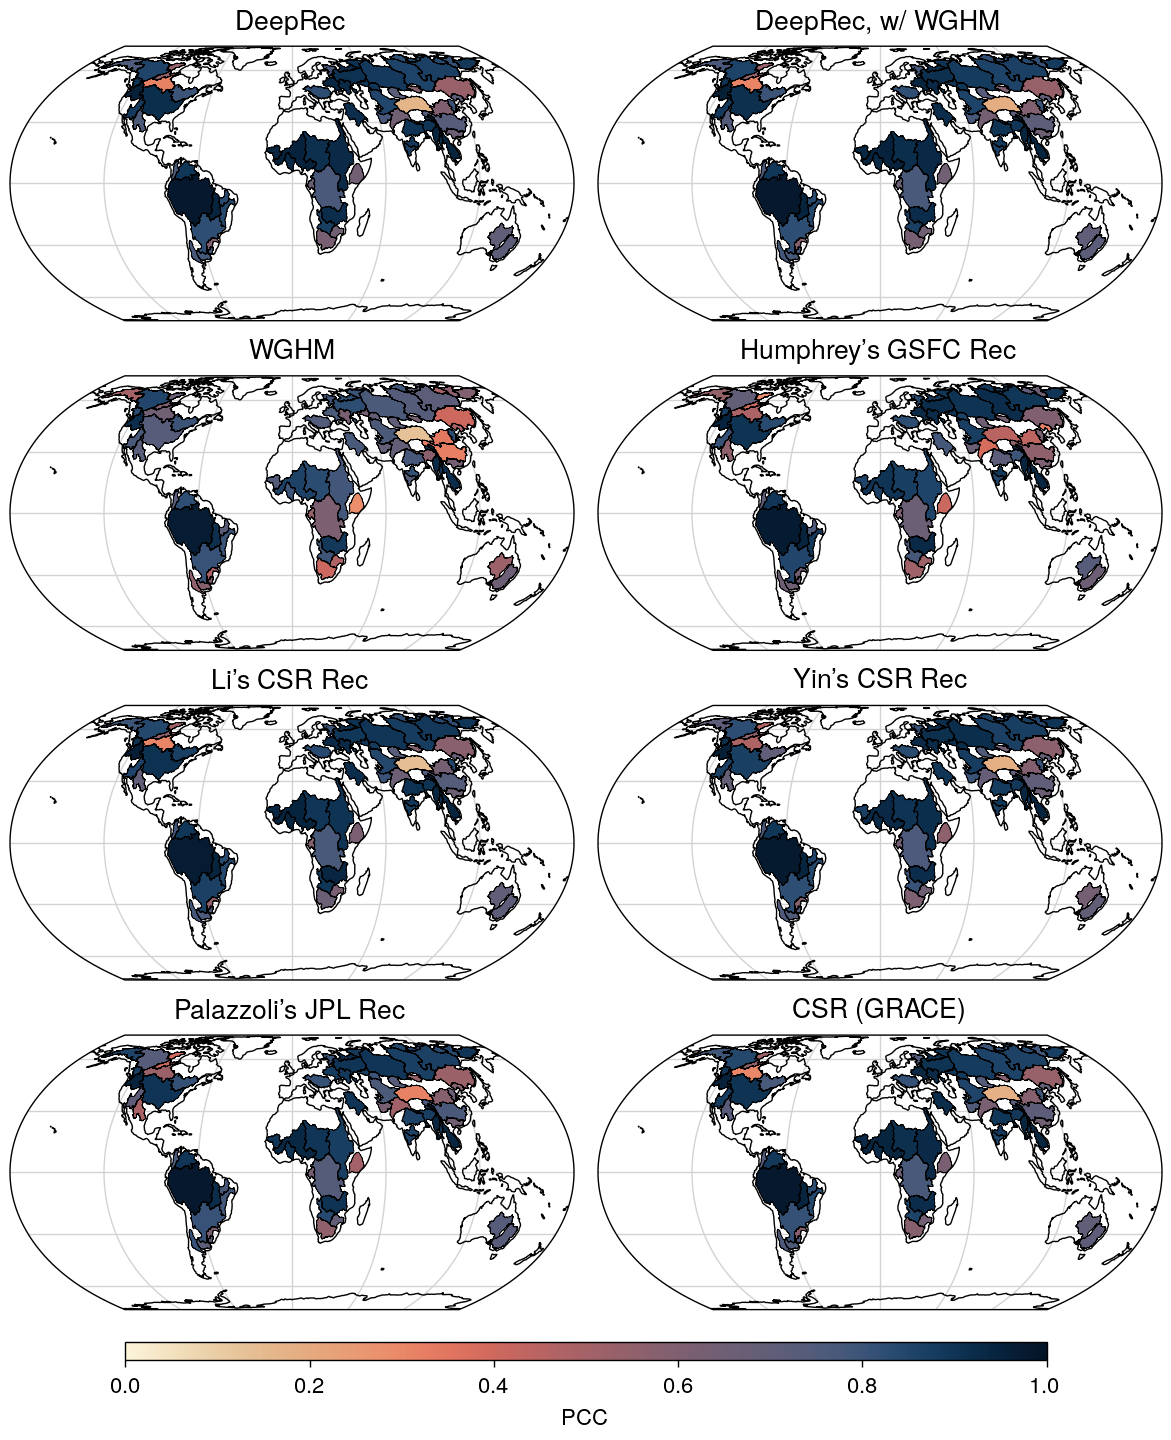

In [22]:
p = da_pcc_post.dr.projplot_basins(
    da_dummy_post,
    col="model",
    figsize=(6, 8.25),
    **plot_kwargs,
)

# Plot basin shapes
for ax, model in zip(p.axs.flat, da_pcc_post.model.values):
    ax.set_title(vars_verbose[model])
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(
    FIGURE_DIR / f"slr_pcc_{times_post[0].year}-{times_post[-1].year}.pdf",
    backend="pgf",
)
